<a href="https://colab.research.google.com/github/camdsDS/Cesar_Portfolio/blob/main/HousePrices_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# impede avisos desnecessários
import warnings
warnings.filterwarnings('ignore')

# Funções

In [3]:
def unique_cat(df):
    '''
    Devolve a quantidade de valores únicos por feature categórica.
    '''
    dict_unique_cat = {}
    for column in df.columns:
        if df[column].dtype == 'object': 
            dict_unique_cat[column] = len(df[column].unique())

    df_unique = pd.DataFrame(list(dict_unique_cat.items()), columns=['coluna_cat', 'quantidade de unique'])
    return df_unique.sort_values('quantidade de unique', ascending = False)

In [4]:
def relatorio(data, target):
    '''
    Devolve um relatorio sobre valores miss no df, valor da bad rate,
    tipos de dados e correlação de Pearson.   
    '''
    print('Relatorio de miss')
    df_miss = ((data.isna().sum()/len(data))*100).to_frame().reset_index().rename(columns={'index': 'column', 0:'%_miss'}).sort_values('%_miss', ascending = False)
    if df_miss['%_miss'].tolist()[0] == 0:
        print('O df não apresenta valores miss.')
    else:
        print('O df apresenta valores miss e as cinco colunas com maior concentração de miss são:')
        print(df_miss.head())
    
    import missingno as msn
    print('\nGráfico missingno: as partes brancas representam dados nulos (missing).')
    msn.matrix(data)
    plt.show()

    print('\nRelatorio de zeros')
    print ('Segue a concentração, em porcentagem, de valores zero por coluna do df:')
    dict_de_zeros = {}
    for column in data.columns:
        if data[column].value_counts().index[0]==0:
            dict_de_zeros[column] = round(((data[column].value_counts()[0]/data[column].value_counts().sum())*100),2)

    zeros = pd.DataFrame(list(dict_de_zeros.items()),
                   columns=['colunas', '%_zeros'])
    print(zeros.sort_values('%_zeros', ascending = False))
        
    #Correlação de Pearson
    print('\nCorrelação de Pearson:')
    corr = data.corr()
    highest_corr_features = corr.index[abs(corr[target])>0.5]
    plt.figure(figsize=(10,10))
    g = sns.heatmap(data[highest_corr_features].corr(),annot=True,cmap="RdYlGn")

In [5]:
def RelatorioMiss(df):
    '''
    Retorna a % de miss de cada coluna do df.
    '''
    df_miss = ((df.isna().sum()/len(df))*100).to_frame().rename(columns={0:'P_miss'}).reset_index().sort_values('P_miss', ascending = False)
    return df_miss

# Lendo dados de Treino

In [6]:
# Dados do kaggle: House Prices - Advanced Regression Techniques
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
data = pd.read_csv('train.csv')

In [7]:
data['MSSubClass'] = [str(x)+'_cat' for x in data['MSSubClass']]

# Relatatórios

## Relatório completo (ProfileReport do pandas_profiling)

In [8]:
%load_ext autoreload
%autoreload 2

import sys

# !"{sys.executable}" -m pip install -U pandas-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension

from pathlib import Path

import pandas as pd
from ipywidgets import widgets

from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file

profile = ProfileReport(
                        data, title="House Prices", html={"style": {"full_width": True}}, sort="None"
                        )
profile.to_file("report_House_Prices.html") #abra o arquivo .html que foi upado

Summarize dataset:   0%|          | 0/94 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Relatório simples

Relatorio de miss
O df apresenta valores miss e as cinco colunas com maior concentração de miss são:
         column     %_miss
72       PoolQC  99.520548
74  MiscFeature  96.301370
6         Alley  93.767123
73        Fence  80.753425
57  FireplaceQu  47.260274

Gráfico missingno: as partes brancas representam dados nulos (missing).


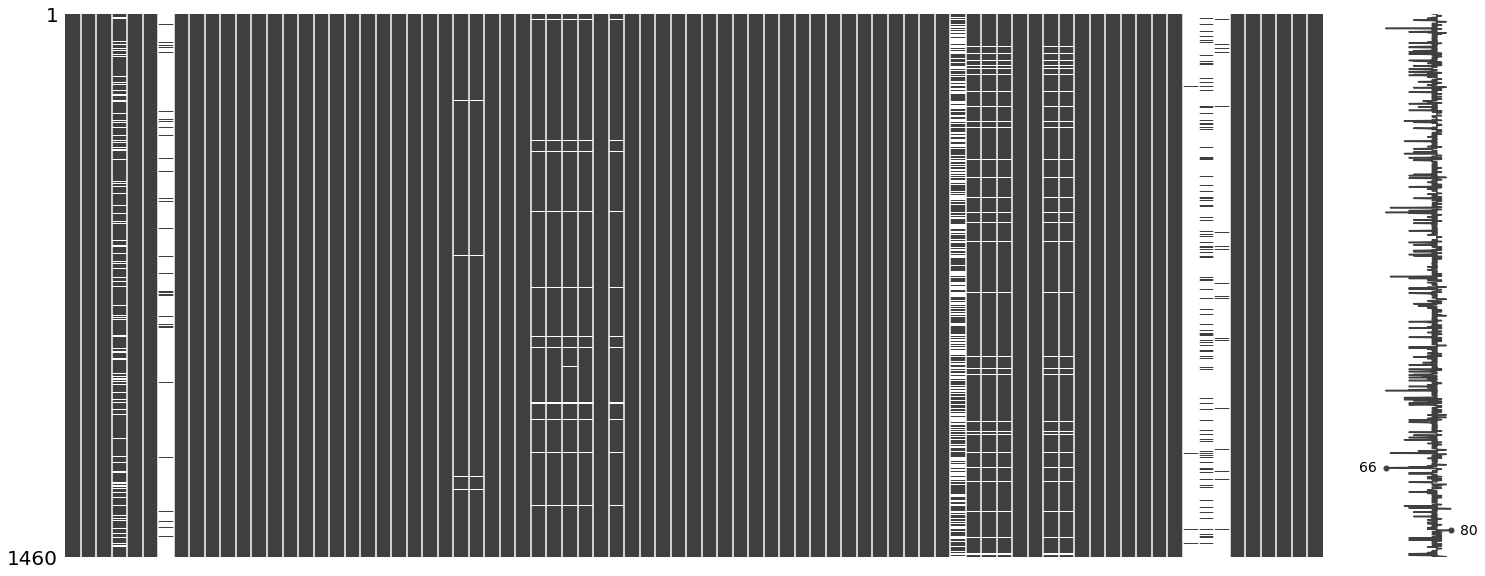


Relatorio de zeros
O df apresenta valores zero e as cinco colunas com maior concentração de miss são:
          colunas  %_zeros
17       PoolArea    99.52
15      3SsnPorch    98.36
6    LowQualFinSF    98.22
18        MiscVal    96.44
8    BsmtHalfBath    94.38
16    ScreenPorch    92.05
2      BsmtFinSF2    88.56
14  EnclosedPorch    85.75
9        HalfBath    62.53
0      MasVnrArea    59.30
7    BsmtFullBath    58.63
5        2ndFlrSF    56.78
12     WoodDeckSF    52.12
10     Fireplaces    47.26
13    OpenPorchSF    44.93
1      BsmtFinSF1    31.99
3       BsmtUnfSF     8.08
11     GarageArea     5.55
4     TotalBsmtSF     2.53

Correlação de Pearson:


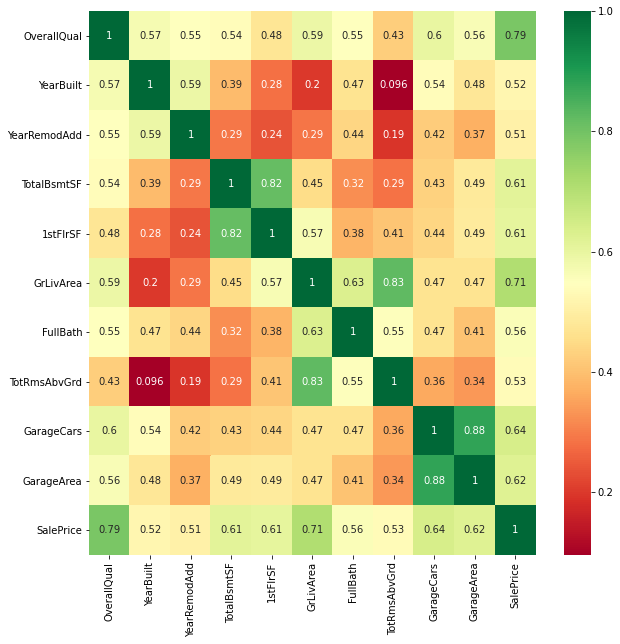

In [9]:
relatorio(data, 'SalePrice')

#### Distribuição dos valores-alvo do df de treino

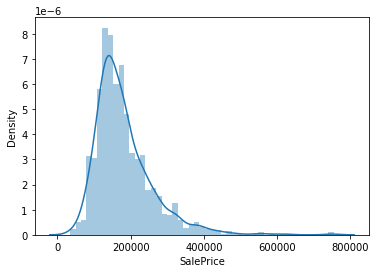

In [10]:
 sns.distplot(data['SalePrice'])

# Montando o df de treino

In [11]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60_cat,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20_cat,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60_cat,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70_cat,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60_cat,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
data_train = data.copy()
id = data_train['Id']
y = data_train['SalePrice']
#Dropando id, alvo e features com mais de 90% de miss ou mais de 90% de zeros (desde que a feature não seja do tipo binário):
data_train = data_train.drop(['Id', 'SalePrice', 'PoolQC', 'MiscFeature', 'Alley', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'ScreenPorch'], axis=1)

# Montando os dataframes categóricos (alta e baixa cardinalidade) e numéricos

## DF categórico de alta cardinalidade

In [13]:
unique_cat(data_train).head()

,coluna_cat,quantidade de unique
8,Neighborhood,25
16,Exterior2nd,16
0,MSSubClass,15
15,Exterior1st,15
9,Condition1,9


In [14]:
# As 3 primeiras linhas do df acima se referem a colunas categóricas com
# mais de 10 domínios.
# Vamos classificá-los como categóricos de alta cardinalidade. 
lista_categoricoAltaC = list(unique_cat(data_train).iloc[0:4, 0])
df_categoricoAltaC = data_train[lista_categoricoAltaC]

In [15]:
dominios_categorico_AltaC = {}
for column in df_categoricoAltaC.columns:
    dominios_categorico_AltaC[column] = list(df_categoricoAltaC[column].unique())

## DF categórico de baixa cardinalidade

In [16]:
#Os demais serão categóricos de baixa cardinalidade
lista_categoricoBaixaC = list(unique_cat(data_train).iloc[4:, 0])
df_categoricoBaixaC = data_train[lista_categoricoBaixaC]

In [17]:
dominios_categorico_BaixaC = {}
for column in df_categoricoBaixaC.columns:
    dominios_categorico_BaixaC[column] = list(df_categoricoBaixaC[column].unique())

## DF numérico

In [18]:
lista_numerico = []
for column in data_train.columns:
        if data_train[column].dtype == 'int64' or data_train[column].dtype == 'float64':
            lista_numerico.append(column)

df_numerico = data_train[lista_numerico]
df_numerico

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,1710,1,2,1,3,1,8,0,2003.0,2,548,0,61,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,1262,0,2,0,3,1,6,1,1976.0,2,460,298,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,1786,1,2,1,3,1,6,1,2001.0,2,608,0,42,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,1717,1,1,0,3,1,7,1,1998.0,3,642,0,35,272,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,2198,1,2,1,4,1,9,1,2000.0,3,836,192,84,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,1647,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,8,2007
1456,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,2073,1,2,0,3,1,7,2,1978.0,2,500,349,0,0,2,2010
1457,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,2340,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,5,2010
1458,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,1078,1,1,0,2,1,5,0,1950.0,1,240,366,0,112,4,2010


### Preenchendo valores miss no df numérico

In [19]:
from sklearn.impute import SimpleImputer

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(df_numerico)
df_numerico_tratado = pd.DataFrame(imp_median.transform(df_numerico), columns=df_numerico.columns)
df_numerico_tratado.index = df_numerico.index

## Transformando as categóricas em numéricas

### Categórico de Alta Cardinalidade

#### Redução de cardinalidade da primeira das quatro colunas: Neighborhood

In [20]:
dict_dominio_Neighborhood = {'dominio_Neighborhood_top1':[], 'dominio_Neighborhood_top2':[], 'dominio_Neighborhood_top3':[], 'dominio_Neighborhood_top4':[], 'dominio_Neighborhood_top5':[]}
i = 0
for dict in dict_dominio_Neighborhood:
    cinco = 0
    while cinco<5 and i<len(df_categoricoAltaC['Neighborhood'].value_counts(sort=True, ascending=False)):
        dict_dominio_Neighborhood[dict].append(df_categoricoAltaC['Neighborhood'].value_counts(sort=True, ascending=False).index[i])
        cinco += 1
        i +=1

In [21]:
for pos_elemento in range(len(df_categoricoAltaC['Neighborhood'])):
    if df_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top1']:
        df_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top1'
    elif df_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top2']:
        df_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top2'
    elif df_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top3']:
        df_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top3'
    elif df_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top4']:
        df_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top4'
    elif df_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top5']:
        df_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top5'
    else:
        df_categoricoAltaC['Neighborhood'][pos_elemento] = 'outros'

#### Redução de cardinalidade da segunda das quatro colunas: Exterior2nd

In [22]:
dict_dominio_Exterior2nd = {'dominio_Exterior2nd_top1':[], 'dominio_Exterior2nd_top2':[], 'dominio_Exterior2nd_top3':[]}
i = 0
for dict in dict_dominio_Exterior2nd:
    cinco = 0
    while cinco<5 and i<len(df_categoricoAltaC['Exterior2nd'].value_counts(sort=True, ascending=False)):
        dict_dominio_Exterior2nd[dict].append(df_categoricoAltaC['Exterior2nd'].value_counts(sort=True, ascending=False).index[i])
        cinco += 1
        i +=1

In [23]:
for pos_elemento in range(len(df_categoricoAltaC['Exterior2nd'])):
    if df_categoricoAltaC['Exterior2nd'][pos_elemento] in dict_dominio_Exterior2nd['dominio_Exterior2nd_top1']:
        df_categoricoAltaC['Exterior2nd'][pos_elemento] = 'Exterior2nd_top1'
    elif df_categoricoAltaC['Exterior2nd'][pos_elemento] in dict_dominio_Exterior2nd['dominio_Exterior2nd_top2']:
        df_categoricoAltaC['Exterior2nd'][pos_elemento] = 'Exterior2nd_top2'
    elif df_categoricoAltaC['Exterior2nd'][pos_elemento] in dict_dominio_Exterior2nd['dominio_Exterior2nd_top3']:
        df_categoricoAltaC['Exterior2nd'][pos_elemento] = 'Exterior2nd_top3'
    else:
        df_categoricoAltaC['Exterior2nd'][pos_elemento] = 'outros'

#### Redução de cardinalidade da segunda das quatro colunas: MSSubClass

In [24]:
dict_dominio_MSSubClass = {'dominio_MSSubClass_top1':[], 'dominio_MSSubClass_top2':[], 'dominio_MSSubClass_top3':[]}
i = 0
for dict in dict_dominio_MSSubClass:
    cinco = 0
    while cinco<5 and i<len(df_categoricoAltaC['MSSubClass'].value_counts(sort=True, ascending=False)):
        dict_dominio_MSSubClass[dict].append(df_categoricoAltaC['MSSubClass'].value_counts(sort=True, ascending=False).index[i])
        cinco += 1
        i +=1

In [25]:
for pos_elemento in range(len(df_categoricoAltaC['MSSubClass'])):
    if df_categoricoAltaC['MSSubClass'][pos_elemento] in dict_dominio_MSSubClass['dominio_MSSubClass_top1']:
        df_categoricoAltaC['MSSubClass'][pos_elemento] = 'MSSubClass_top1'
    elif df_categoricoAltaC['MSSubClass'][pos_elemento] in dict_dominio_MSSubClass['dominio_MSSubClass_top2']:
        df_categoricoAltaC['MSSubClass'][pos_elemento] = 'MSSubClass_top2'
    elif df_categoricoAltaC['MSSubClass'][pos_elemento] in dict_dominio_MSSubClass['dominio_MSSubClass_top3']:
        df_categoricoAltaC['MSSubClass'][pos_elemento] = 'MSSubClass_top3'
    else:
        df_categoricoAltaC['MSSubClass'][pos_elemento] = 'outros'

Redução de cardinalidade da segunda das quatro colunas: Exterior1st

In [26]:
dict_dominio_Exterior1st = {'dominio_Exterior1st_top1':[], 'dominio_Exterior1st_top2':[], 'dominio_Exterior1st_top3':[]}
i = 0
for dict in dict_dominio_Exterior1st:
    cinco = 0
    while cinco<5 and i<len(df_categoricoAltaC['Exterior1st'].value_counts(sort=True, ascending=False)):
        dict_dominio_Exterior1st[dict].append(df_categoricoAltaC['Exterior1st'].value_counts(sort=True, ascending=False).index[i])
        cinco += 1
        i +=1

In [27]:
for pos_elemento in range(len(df_categoricoAltaC['Exterior1st'])):
    if df_categoricoAltaC['Exterior1st'][pos_elemento] in dict_dominio_Exterior1st['dominio_Exterior1st_top1']:
        df_categoricoAltaC['Exterior1st'][pos_elemento] = 'Exterior1st_top1'
    elif df_categoricoAltaC['Exterior1st'][pos_elemento] in dict_dominio_Exterior1st['dominio_Exterior1st_top2']:
        df_categoricoAltaC['Exterior1st'][pos_elemento] = 'Exterior1st_top2'
    elif df_categoricoAltaC['Exterior1st'][pos_elemento] in dict_dominio_Exterior1st['dominio_Exterior1st_top3']:
        df_categoricoAltaC['Exterior1st'][pos_elemento] = 'Exterior1st_top3'
    else:
        df_categoricoAltaC['Exterior1st'][pos_elemento] = 'outros'

## Merge entre as categóricas e Dummy

In [28]:
df_categorico_total = pd.merge(df_categoricoAltaC, df_categoricoBaixaC, how= 'left', left_index= True, right_index= True)
df_categorico_dummy = pd.get_dummies(df_categorico_total, dummy_na = True, drop_first=True)

## Juntando os df

In [29]:
#df_categorico + df_numerico_tratado

df_train = pd.merge(df_categorico_dummy, df_numerico_tratado, how= 'left', left_index= True, right_index= True)

## Colocando em escala

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_train)

abt_train = pd.DataFrame(scaler.transform(df_train), columns = df_train.columns)
abt_train.index = df_train.index

#Testando modelos

In [31]:
from sklearn.model_selection import train_test_split

X_desenv, X_valid, y_desenv, y_valid = train_test_split(abt_train, y, train_size = 0.7, test_size = 0.3, random_state = 42)

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

RF = RandomForestRegressor()
GB = GradientBoostingRegressor()

from sklearn.model_selection import GridSearchCV

parametros = {'n_estimators':[80, 100, 120],
              'max_depth':[4,5,6] }
        

gridRF = GridSearchCV(estimator = RF,        
                      param_grid = parametros,  
                      cv = 5)

gridRF.fit(X_desenv,y_desenv)
pd.DataFrame(gridRF.cv_results_)[['params','rank_test_score','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,rank_test_score,mean_test_score
8,"{'max_depth': 6, 'n_estimators': 120}",1,0.800654
6,"{'max_depth': 6, 'n_estimators': 80}",2,0.800405
7,"{'max_depth': 6, 'n_estimators': 100}",3,0.799500
4,"{'max_depth': 5, 'n_estimators': 100}",4,0.786298
3,"{'max_depth': 5, 'n_estimators': 80}",5,0.785793
5,"{'max_depth': 5, 'n_estimators': 120}",6,0.783858
2,"{'max_depth': 4, 'n_estimators': 120}",7,0.763488
0,"{'max_depth': 4, 'n_estimators': 80}",8,0.763255
1,"{'max_depth': 4, 'n_estimators': 100}",9,0.760853


In [33]:
gridGB = GridSearchCV(estimator = GB,        
                      param_grid = parametros,  
                      cv = 5)

gridGB.fit(X_desenv,y_desenv)
pd.DataFrame(gridGB.cv_results_)[['params','rank_test_score','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,rank_test_score,mean_test_score
0,"{'max_depth': 4, 'n_estimators': 80}",1,0.812352
2,"{'max_depth': 4, 'n_estimators': 120}",2,0.811905
8,"{'max_depth': 6, 'n_estimators': 120}",3,0.808025
1,"{'max_depth': 4, 'n_estimators': 100}",4,0.801106
7,"{'max_depth': 6, 'n_estimators': 100}",5,0.798669
4,"{'max_depth': 5, 'n_estimators': 100}",6,0.793187
6,"{'max_depth': 6, 'n_estimators': 80}",7,0.788427
5,"{'max_depth': 5, 'n_estimators': 120}",8,0.785142
3,"{'max_depth': 5, 'n_estimators': 80}",9,0.783609


In [34]:
from sklearn.metrics import mean_squared_error

print('RF')
print('Erro desenv')
erro_desenv_RF = mean_squared_error(y_desenv, gridRF.predict(X_desenv))
print(np.sqrt(erro_desenv_RF))
print('Erro valid')
erro_valid_RF = mean_squared_error(y_valid, gridRF.predict(X_valid))
print(np.sqrt(erro_valid_RF))


print('\nGB')
print('Erro desenv')
erro_desenv_GB = mean_squared_error(y_desenv, gridGB.predict(X_desenv))
print(np.sqrt(erro_desenv_GB))
print('Erro valid')
erro_valid_GB = mean_squared_error(y_valid, gridGB.predict(X_valid))
print(np.sqrt(erro_valid_GB))

RF
Erro desenv
19777.36241866055
Erro valid
28216.008419429232

GB
Erro desenv
10633.784426260212
Erro valid
24495.384133078078


In [35]:
print('Diferença simples (em módulo) entre previsão e real - dados de validação')
data_df_diferenca = [ list(y_valid), list(gridGB.predict(X_valid)), list(abs(((gridGB.predict(X_valid)*100)/y_valid)-100)), list(abs(y_valid - gridGB.predict(X_valid))) ]
data_df_diferenca = np.array(data_df_diferenca)
data_df_diferenca = data_df_diferenca.T

df_diferenca = pd.DataFrame(data_df_diferenca, columns=['valor_real', 'valor_predito', 'módulo da % da variação', 'módulo da diferença'])
df_diferenca = df_diferenca.sort_values(by='módulo da % da variação', ascending=True)

print('As cinco menores diferenças:')
df_diferenca.head()

Diferença simples (em módulo) entre previsão e real - dados de validação
As cinco menores diferenças:


,valor_real,valor_predito,módulo da % da variação,módulo da diferença
18,118400.0,118445.761503,0.038650,45.761503
15,134500.0,134418.168401,0.060841,81.831599
435,205950.0,206082.079410,0.064132,132.079410
371,172400.0,172652.020636,0.146184,252.020636
423,175000.0,174696.319163,0.173532,303.680837


In [36]:
print('\nAs cinco maiores diferenças:')
df_diferenca = df_diferenca.sort_values(by='módulo da % da variação', ascending=False)
df_diferenca.head()


As cinco maiores diferenças:


,valor_real,valor_predito,módulo da % da variação,módulo da diferença
197,40000.0,86479.629094,116.199073,46479.629094
430,62383.0,122547.987152,96.444524,60164.987152
181,55993.0,102523.689616,83.100905,46530.689616
134,35311.0,62705.354476,77.580228,27394.354476
227,64500.0,106546.533021,65.188423,42046.533021


#### Importância das variáveis

In [37]:
model = gridGB.best_estimator_

var_e_imp = pd.DataFrame({'Variaveis':abt_train.columns.tolist(), 'Importancia':model.feature_importances_.tolist()}).sort_values('Importancia', ascending=False).reset_index(drop=True)

var_e_imp.head()

,Variaveis,Importancia
0,OverallQual,0.524756
1,GrLivArea,0.131478
2,GarageCars,0.048181
3,2ndFlrSF,0.043430
4,TotalBsmtSF,0.034681


## Teste

In [38]:
data2 = pd.read_csv('test.csv')

In [39]:
data2['MSSubClass'] = [str(x)+'_cat' for x in data2['MSSubClass']]

In [40]:
data_test = data2.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'ScreenPorch'], axis=1)

In [41]:
df_test_categoricoAltaC = data_test[lista_categoricoAltaC]
df_test_categoricoBaixaC = data_test[lista_categoricoBaixaC]
df_test_numerico = data_test[lista_numerico]

In [42]:
df_test_numerico_tratado = pd.DataFrame(imp_median.transform(df_test_numerico), columns=df_test_numerico.columns)
df_test_numerico_tratado.index = df_test_numerico.index

In [43]:
for pos_elemento in range(len(df_test_categoricoAltaC['Neighborhood'])):
    if df_test_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top1']:
        df_test_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top1'
    elif df_test_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top2']:
        df_test_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top2'
    elif df_test_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top3']:
        df_test_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top3'
    elif df_test_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top4']:
        df_test_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top4'
    elif df_test_categoricoAltaC['Neighborhood'][pos_elemento] in dict_dominio_Neighborhood['dominio_Neighborhood_top5']:
        df_test_categoricoAltaC['Neighborhood'][pos_elemento] = 'Neighborhood_top5'
    else:
        df_test_categoricoAltaC['Neighborhood'][pos_elemento] = 'outros'

In [44]:
for pos_elemento in range(len(df_test_categoricoAltaC['Exterior2nd'])):
    if df_test_categoricoAltaC['Exterior2nd'][pos_elemento] in dict_dominio_Exterior2nd['dominio_Exterior2nd_top1']:
        df_test_categoricoAltaC['Exterior2nd'][pos_elemento] = 'Exterior2nd_top1'
    elif df_test_categoricoAltaC['Exterior2nd'][pos_elemento] in dict_dominio_Exterior2nd['dominio_Exterior2nd_top2']:
        df_test_categoricoAltaC['Exterior2nd'][pos_elemento] = 'Exterior2nd_top2'
    elif df_test_categoricoAltaC['Exterior2nd'][pos_elemento] in dict_dominio_Exterior2nd['dominio_Exterior2nd_top3']:
        df_test_categoricoAltaC['Exterior2nd'][pos_elemento] = 'Exterior2nd_top3'
    else:
        df_test_categoricoAltaC['Exterior2nd'][pos_elemento] = 'outros'

In [45]:
for pos_elemento in range(len(df_test_categoricoAltaC['MSSubClass'])):
    if df_test_categoricoAltaC['MSSubClass'][pos_elemento] in dict_dominio_MSSubClass['dominio_MSSubClass_top1']:
        df_test_categoricoAltaC['MSSubClass'][pos_elemento] = 'MSSubClass_top1'
    elif df_test_categoricoAltaC['MSSubClass'][pos_elemento] in dict_dominio_MSSubClass['dominio_MSSubClass_top2']:
        df_test_categoricoAltaC['MSSubClass'][pos_elemento] = 'MSSubClass_top2'
    elif df_test_categoricoAltaC['MSSubClass'][pos_elemento] in dict_dominio_MSSubClass['dominio_MSSubClass_top3']:
        df_test_categoricoAltaC['MSSubClass'][pos_elemento] = 'MSSubClass_top3'
    else:
        df_test_categoricoAltaC['MSSubClass'][pos_elemento] = 'outros'

In [46]:
for pos_elemento in range(len(df_test_categoricoAltaC['Exterior1st'])):
    if df_test_categoricoAltaC['Exterior1st'][pos_elemento] in dict_dominio_Exterior1st['dominio_Exterior1st_top1']:
        df_test_categoricoAltaC['Exterior1st'][pos_elemento] = 'Exterior1st_top1'
    elif df_test_categoricoAltaC['Exterior1st'][pos_elemento] in dict_dominio_Exterior1st['dominio_Exterior1st_top2']:
        df_test_categoricoAltaC['Exterior1st'][pos_elemento] = 'Exterior1st_top2'
    elif df_test_categoricoAltaC['Exterior1st'][pos_elemento] in dict_dominio_Exterior1st['dominio_Exterior1st_top3']:
        df_test_categoricoAltaC['Exterior1st'][pos_elemento] = 'Exterior1st_top3'
    else:
        df_test_categoricoAltaC['Exterior1st'][pos_elemento] = 'outros'

In [47]:
df_test_categorico_total = pd.merge(df_test_categoricoAltaC, df_test_categoricoBaixaC, how= 'left', left_index= True, right_index= True)
df_test_categorico_dummy = pd.get_dummies(df_test_categorico_total, dummy_na = True, drop_first=True)

In [48]:
#df_categorico + df_numerico_tratado

df_test = pd.merge(df_test_categorico_dummy, df_test_numerico_tratado, how= 'left', left_index= True, right_index= True)

In [49]:
scaler2 = MinMaxScaler()
scaler2.fit(df_test)

abt_test = pd.DataFrame(scaler2.transform(df_test), columns = df_test.columns)
abt_test.index = df_test.index

In [50]:
#criando listas para comparar os df train e test
lista_colunas_train = abt_train.columns.to_list()
lista_colunas_test = abt_test.columns.to_list()

In [51]:
#comparando (vendo o que está no train e não está no test)
Z = set(lista_colunas_train) - set(lista_colunas_test)
Z

{'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'GarageQual_Fa',
 'Heating_GasA',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'RoofMatl_CompShg',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Utilities_NoSeWa'}

In [52]:
for col in Z:
  abt_test[col] = 0

In [53]:
#atualizando
lista_colunas_train = abt_train.columns.to_list()
lista_colunas_test = abt_test.columns.to_list()

In [54]:
#comparando (vendo o que está no test e não está no train)
Z = set(lista_colunas_test) - set(lista_colunas_train)
Z

{'Exterior1st_outros', 'MSSubClass_outros'}

In [55]:
#dropando do test o que está no test e não está no train
abt_test = abt_test.drop(list(Z), axis = 1)

In [56]:
#atualizando(2)
lista_colunas_train = abt_train.columns.to_list()
lista_colunas_test = abt_test.columns.to_list()

In [57]:
#verificando se agora as colunas estão iguais
set(lista_colunas_test) == set(lista_colunas_train)

True

In [58]:
abt_test.columns == abt_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [59]:
abt_test = abt_test[list(abt_train.columns)]

In [60]:
abt_test.columns == abt_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [61]:
pred_test = gridGB.predict(abt_test)

output = pd.DataFrame({'Id': data2['Id'], 'SalePrice': pred_test})
output.to_csv('Submission_HousePrices2.csv', index=False)